In [1]:
import pandas as pd
import numpy as np
import sys
from typing import Dict
from pandas.tseries.offsets import MonthEnd
from pyspark.sql import SparkSession
from datetime import datetime
sys.path.append('..')
import plotly.express as px
from tqdm.notebook import tqdm
from copy import deepcopy
import os
from core.models.utils import run_spark_session

from core.calculator.storage import ModelDB
from core.calculator.core import TrainingManager
from core.models import DepositModels
from datetime import date

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Чтение данных, обучение моделей, получение предиктов

In [3]:
spark = run_spark_session(f'model_check')

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/09 18:34:20 WARN ipc.Client: Exception encountered while connecting to the server : org.apache.hadoop.ipc.RemoteException(org.apache.hadoop.ipc.StandbyException): Operation category READ is not supported in state standby. Visit https://s.apache.org/sbnn-error
23/11/09 18:34:21 WARN ipc.Client: Exception encountered while connecting to the server : org.apache.hadoop.ipc.RemoteException(org.apache.hadoop.ipc.StandbyException): Operation category READ is not supported in state standby. Visit https://s.apache.org/sbnn-error
23/11/09 18:34:22 WARN yarn.Client: Same path resource file:///opt/cloudera/parcels/AnacondaPy37/jars/spark-tree-plotting-0.2.jar added multiple times to distributed cache.
23/11/09 18:34:38 WARN ipc.Client: Exception encountered while connecting to the server : org.apache.hadoop.ipc.RemoteException(org.apache.hadoop.ipc.StandbyExceptio

In [4]:
# последняя самая актуальная дата на которую хотим обучать модели
end_date = datetime(2023,9,30)

In [5]:
# название интересующей нас модели
model_name = 'newbusiness_mass'

In [6]:
start_date = (DepositModels.models_dict[model_name].data_loader.default_start_date)

In [7]:
data_models = DepositModels.models_dict[model_name].data_loader.get_training_data(spark, start_date, end_date)

In [12]:
dir(DepositModels.models_dict[model_name].data_loader)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_get_data',
 'default_start_date',
 'estimator',
 'features',
 'full_features',
 'get_ground_truth',
 'get_maximum_train_range',
 'get_portfolio',
 'get_prediction_data',
 'get_prediction_data_standalone',
 'get_training_data',
 'min_model_predict',
 'model_name',
 'table_date_col',
 'table_name',
 'target']

In [8]:
# глубина теста

depth = 6

In [9]:
X_train = data_models['features'].iloc[:-depth, :]
y_train = data_models['target'].iloc[:-depth, :]

In [10]:
X_test = data_models['features'].iloc[-depth:, :]
y_test = data_models['target'].iloc[-depth:, :]

In [11]:
min(y_test.index)

Timestamp('2023-04-30 00:00:00')

In [12]:
# загружаем класс модели

model = DepositModels.models_dict[model_name].model_trainer.model

In [13]:
model.fit(X_train, y_train)

In [14]:
pred = (model.predict(X_test))

## Проверки после обучения

Видно что при росте ставок за сентябрь и октябрь модели недопрогнозит  
Это может быть связано с отсутствием учета досрочного отзыва и операций - данные параметры идут как надстройка при выполнении модели (прогнозные значения отзыва перетекают в новый бизнес уже после прогноза обоих моделей, как доп фактор не встроен в данный момент)  

In [15]:
import matplotlib.pyplot as plt

(array([19478., 19509., 19539., 19570., 19601., 19631.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

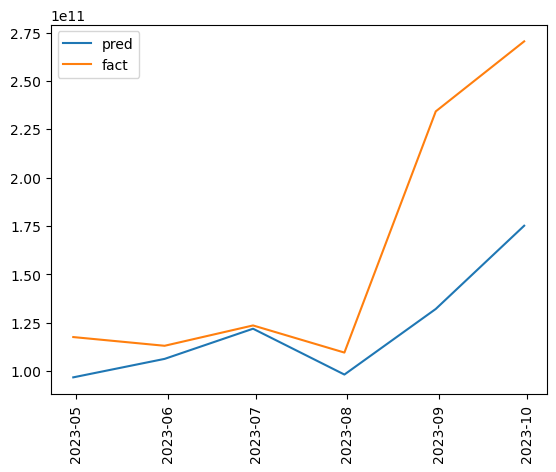

In [16]:
plt.plot(pred, label='pred')
plt.plot(y_test, label='fact')
plt.legend()
plt.xticks(rotation=90)

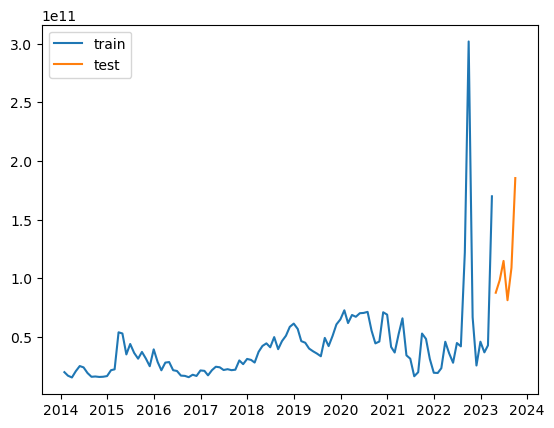

In [17]:
plt.plot(X_train['plan_close_[mass]'], label='train')
plt.plot(X_test['plan_close_[mass]'], label='test')
plt.legend()

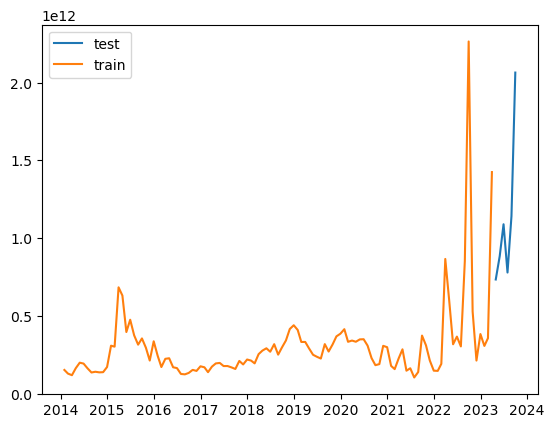

In [18]:
plt.plot((abs(X_test['plan_close_[mass]']) * X_test['VTB_max_rate_[mass]']), label='test')
plt.plot((abs(X_train['plan_close_[mass]']) * X_train['VTB_max_rate_[mass]']), label='train')
plt.legend()

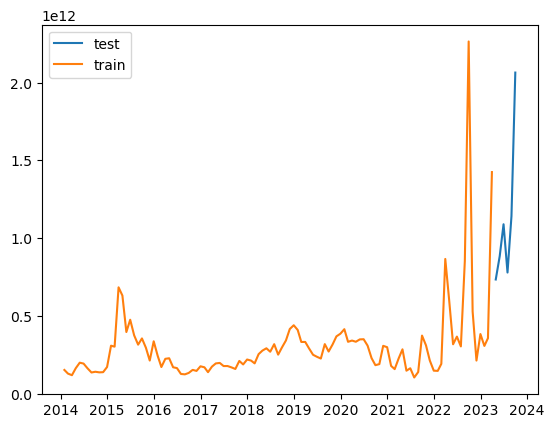

In [19]:
plt.plot((abs(X_test['plan_close_[mass]']) * X_test['VTB_max_rate_[mass]']), label='test')
plt.plot((abs(X_train['plan_close_[mass]']) * X_train['VTB_max_rate_[mass]']), label='train')
plt.legend()

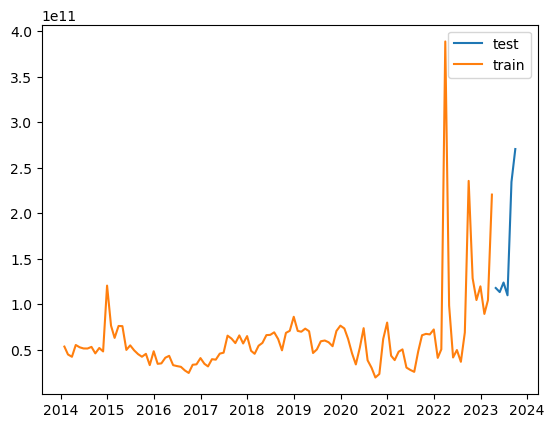

In [20]:
plt.plot(y_test, label='test')
plt.plot(y_train, label='train')
plt.legend()

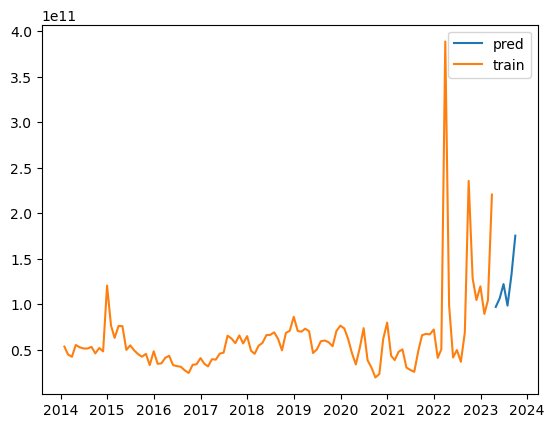

In [21]:
plt.plot(pred, label='pred')
plt.plot(y_train, label='train')
plt.legend()

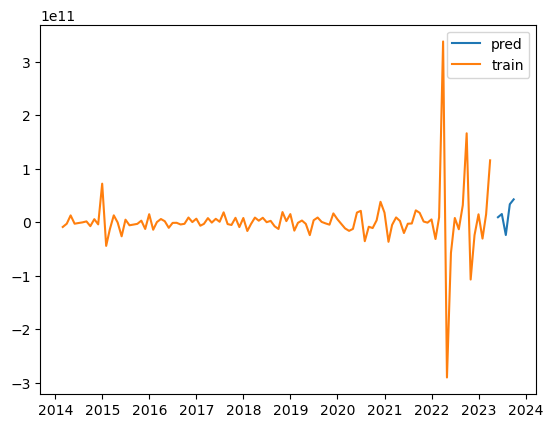

In [22]:
plt.plot(pred.diff(), label='pred')
plt.plot(y_train.diff(), label='train')
plt.legend()


In [23]:
y_train.nlargest(3, 'y_inflow_[mass]')

,y_inflow_[mass]
report_dt,
2022-03-31,3.887235e+11
2022-09-30,2.354246e+11
2023-03-31,2.203652e+11


In [24]:
X_train.nlargest(3, 'plan_close_[mass]')['plan_close_[mass]']

report_dt
2022-09-30    3.018058e+11
2023-03-31    1.698459e+11
2022-08-31    1.220298e+11
Name: plan_close_[mass], dtype: float64

In [25]:
X_test.nlargest(3, 'VTB_weighted_rate_[mass]_[r0s0]')['VTB_weighted_rate_[mass]_[r0s0]']

report_dt
2023-09-30    9.533766
2023-08-31    8.871327
2023-07-31    7.311791
Name: VTB_weighted_rate_[mass]_[r0s0], dtype: float64

In [26]:
X_test.nlargest(3, 'VTB_max_rate_[mass]')['VTB_max_rate_[mass]']

report_dt
2023-09-30    11.133333
2023-08-31    10.483871
2023-07-31     9.596774
Name: VTB_max_rate_[mass], dtype: float64